In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from IPython.display import clear_output
import torchvision.datasets as dset

In [2]:
# input dimensions
img_size = 28
channels = 1
img_shape = (channels,img_size, img_size)
flatten_img_shape = np.prod(img_shape)
z_dim    = 100

In [3]:
# hyperparamters
epochs = 3
lr = 0.001
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [4]:
#reshape module
class Reshape(nn.Module):
    def __init__(self, args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [5]:
### generator
generator = nn.Sequential(
    nn.Linear(z_dim, 256*5*5),
    Reshape((-1,256,5,5)),
    nn.ConvTranspose2d(256,128,  stride=2, padding=0, kernel_size=3,),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(negative_slope=0.01),
    
    nn.ConvTranspose2d(128,64, stride=1, padding=0, kernel_size=3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(negative_slope=0.01),
    
    nn.ConvTranspose2d(64,1, stride=2, padding=0,output_padding=1, kernel_size=3),
    nn.Tanh(),
).to(device)

In [6]:
#discriminator
discriminator = nn.Sequential(
            nn.Conv2d(1,32, stride=2, kernel_size=3),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Conv2d(32,64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Conv2d(64,128, stride=2, padding=0,kernel_size=3),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
    
            nn.Conv2d(128,1, stride=2, padding=0,kernel_size=1),
            nn.Sigmoid(),
            Reshape((-1,1))
).to(device)

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = (image_tensor.reshape(-1, *size) * 0.5) + 0.5
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.show()

In [8]:
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=lr )
dis_optimizer = torch.optim.Adam(discriminator.parameters(),lr=lr)
criterion = torch.nn.BCELoss()

In [9]:
def train(gen, dis, gen_optimizer, dis_optimizer, criterion, batch_size, z_dim, epochs):
    d_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('files/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.5,), (0.5,))])), 
        batch_size=batch_size, shuffle=True, drop_last=True)
    
    avg_gen_loss = []
    avg_dis_loss = []
    for epoch in tqdm(range(epochs)):
        epoch_gen_loss = []
        epoch_dis_loss = []
        for i,x in tqdm(enumerate(d_loader,0)):
            x = x[0].to(device)
            x_size = x.shape[0]
            label_fake = torch.zeros((batch_size,1)).to(device)
            label_real = torch.ones((x_size,1)).to(device)
            #----------------------
            #training discriminator
            #----------------------
            #*** training on real images ****
            real_imgs = x
            dis_optimizer.zero_grad()
    
            real_dis_pred = dis(real_imgs)
            real_dis_loss = criterion(real_dis_pred, label_real)
            real_dis_loss.backward()

            noise = torch.randn((batch_size,z_dim),device = device) #
            
            #*** training on fake images ****
            with torch.no_grad():
                fake_imgs = gen(noise).to(device).detach()
                
            fake_dis_pred = dis(fake_imgs)
            fake_dis_loss = criterion(fake_dis_pred, label_fake)
            fake_dis_loss.backward()
            fake_mean_loss1 = fake_dis_loss.mean().item()
            real_mean_loss = real_dis_loss.mean().item()
            dis_loss = fake_mean_loss1+ real_mean_loss
            epoch_dis_loss.append(dis_loss)
            
            dis_optimizer.step()
            
            #----------------------
            #training generator
            #----------------------
            noise = torch.randn((batch_size,z_dim),device = device)
            fake_imgs = gen(noise)
            dis_pred = dis(fake_imgs).to(device)
            gen_loss = criterion(dis_pred, label_real) 
            epoch_gen_loss.append(gen_loss.mean().item())
            
            gen_optimizer.zero_grad()
            gen_loss.backward()
            fake_mean_loss2 = gen_loss.mean().item()
            gen_optimizer.step()
            
            
        mean_gen_loss = np.mean(epoch_gen_loss)
        mean_dis_loss = np.mean(epoch_dis_loss)
        avg_gen_loss.append(mean_gen_loss)
        avg_dis_loss.append(mean_dis_loss)
        #print details after each epoch 
        
        #*** printing metrics ****
        clear_output()
        print(f'epoch: {epoch} mean gen loss: {mean_gen_loss} mean dis loss: {mean_dis_loss}')
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(avg_gen_loss, color='r')
        ax2.plot(avg_dis_loss, color='b')
        ax1.set_ylabel('Generator Loss', color='r')
        ax2.set_ylabel('Discriminator Loss', color='b')
        plt.show()
        
        #*** showing sample output of generator ****
        noise = torch.randn((25,z_dim),device = device)
        with torch.no_grad():
            images = generator(noise).cpu().detach()
        show_tensor_images(images)
        
    return avg_gen_loss,avg_dis_loss

epoch: 2 mean gen loss: 2.3566790007909137 mean dis loss: 0.5192152954744796


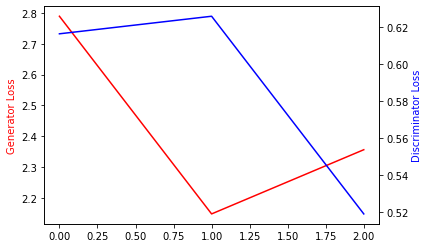

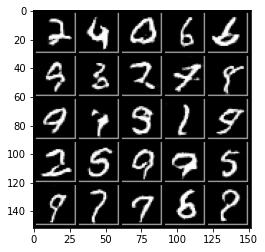

In [10]:
gen_loss, dis_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, criterion, batch_size, z_dim, epochs)

In [11]:
# ConvTranspose2d
# size_fn = lambda side,stride,padding,output_padding,dilation,kernel_size:(side - 1)*stride -2*padding+dilation*(kernel_size - 1)+output_padding+1
# l1=size_fn(5,2,0,0,1,3)
# l2=size_fn(l1,1,0,0,1,3)
# l3=size_fn(l2,2,0,1,1,3)
# print(l1)
# print(l2)
# print(l3)
# Conv2d
# c_size_fn = lambda side, stride, padding,dilation, kernel_size: ((side+2*padding-dilation*(kernel_size-1)-1)/stride)+1
# l1 = c_size_fn(28,2, 0, 1, 3)
# l2 = c_size_fn(l1,2, 0, 1, 3)
# l3 = c_size_fn(l2,2, 1, 1, 3)
# # l4 = c_size_fn(l3,1, 0, 1, 3)
# print(l1)
# print(l2)
# print(l3)
# print(l4)